In [1]:

from dotenv import load_dotenv
import sys, os
sys.path.append('../')
from utils.seed import seed_everything
seed_everything()
load_dotenv('../.env')

EXPERIMENT_DIR=os.getenv('EXPERIMENT_DIR')

## Experiment Settings

In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

test_df = pd.read_csv(os.getenv('TEST_CSV'))
print(f"[INFO] Test Dataset Count : {len(test_df)}")

[INFO] Test Dataset Count : 40


## Dataset Setting

/home/medisc/miniconda3/envs/eiden/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512])


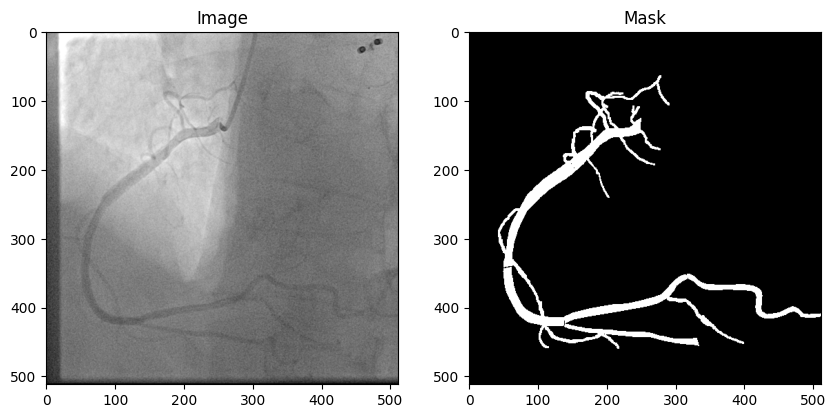

In [3]:
from torch.utils.data import DataLoader
from utils.datasets import CAG_Dataset
from Args import Args_Valid_Loader
Test_Dataset = CAG_Dataset(
    df=test_df,
    image_dir=os.getenv('IMAGE_DIR'),
    mask_dir=os.getenv('MASK_DIR'),
    default_transform = Args_Valid_Loader._get_default_transform(),
    # Prompt_Args = {
    #     "n_shot" : 3
    # }
)

Test_Loader = DataLoader(
    Test_Dataset,
    batch_size=Args_Valid_Loader.valid_bs,
    shuffle=Args_Valid_Loader.shuffle,
    num_workers=Args_Valid_Loader.num_workers,
    pin_memory=Args_Valid_Loader.pin_memory,
)

sample_imgs, sample_masks = next(iter(Test_Loader))
print(sample_imgs.shape, sample_masks.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_imgs[0].squeeze().cpu().numpy(), cmap = 'gray')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(sample_masks[0].squeeze().cpu().numpy(), cmap = 'gray')
plt.title('Mask')
plt.show()

# Model Setting

## FineTuning

In [4]:
from models.DeepSA.model import build_model
from Args import Args_experiments
from models.DeepSA.model import UNet
import torch 

expeirment_name = "DeepSA-FineTuning-v2"

experiment_model_path = os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, 'best_weight.pth')
checkpoint = torch.load(experiment_model_path, map_location = 'cuda')
seg_model = UNet(1, 1, 32, bilinear=True).to(Args_experiments.device)
seg_model.load_state_dict(checkpoint)

print("[INFO] Model Load Complete")

[INFO] Model Load Complete


## Inference

In [5]:
# seg_model = build_model(ckpt_path = os.getenv('deepsa_ckpt_path'), device = Args_experiments.device).to(Args_experiments.device) # DeepSA-Inference


## Test Evaluation

In [6]:
import numpy as np
import pandas as pd
from utils.metrics import SegmentationMetrics

def inference_with_metrics(model, loader, device):
    model.eval()
    preds, imgs, gt_masks = [], [], []
    metrics = {
        "pixel_accuracy": [],
        "mean_pixel_accuracy": [],
        "iou": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "dice_coef": []
    }
    metric_fn = SegmentationMetrics()
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            outputs = model(images)
            pred = torch.sigmoid(outputs)
            pred_bin = (pred > 0.5).float().cpu()
            for i in range(images.size(0)):
                p = pred_bin[i]
                m = masks[i]
                if m.ndim == 2:
                    m = m.unsqueeze(0)
                if p.ndim == 2:
                    p = p.unsqueeze(0)
                imgs.append(images[i].squeeze(0).cpu().numpy())
                gt_masks.append(m.squeeze(0).cpu().numpy())
                preds.append(p.squeeze(0).numpy())
                eval_result = metric_fn.evaluate(p.unsqueeze(0), m.unsqueeze(0))
                for k in metrics.keys():
                    # 소수점 3자리, 반올림
                    metrics[k].append(round(eval_result[k], 3))
    metrics_df = pd.DataFrame(metrics)
    overall_metrics = {k: round(np.mean(v), 3) for k, v in metrics.items()}
    overall_metrics_df = pd.DataFrame([overall_metrics])
    print("개별 metric 통계:\n", metrics_df.describe())
    print("종합 metric(평균):\n", overall_metrics_df)
    return imgs, gt_masks, preds, metrics_df, overall_metrics_df

test_imgs, test_masks, test_preds, test_metrics_df, test_overall_metrics_df = inference_with_metrics(seg_model, Test_Loader, Args_experiments.device)
test_metrics_df.to_csv(os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, "test_metrics.csv"), float_format="%.3f", index=False)
test_overall_metrics_df.to_csv(os.path.join(os.getenv("EXPERIMENT_DIR"), expeirment_name, "test_metrics_overall.csv"), float_format="%.3f", index=False)


개별 metric 통계:
        pixel_accuracy  mean_pixel_accuracy        iou  precision     recall  \
count        40.00000            40.000000  40.000000  40.000000  40.000000   
mean          0.97860             0.877025   0.636475   0.801950   0.763375   
std           0.00674             0.043748   0.081995   0.097984   0.089128   
min           0.96100             0.743000   0.377000   0.398000   0.491000   
25%           0.97375             0.849250   0.607750   0.797750   0.706000   
50%           0.98000             0.880500   0.654500   0.822500   0.771000   
75%           0.98225             0.902750   0.686000   0.856250   0.816000   
max           0.99200             0.957000   0.751000   0.909000   0.934000   

        f1_score  dice_coef  
count  40.000000  40.000000  
mean    0.774600   0.774600  
std     0.066845   0.066845  
min     0.548000   0.548000  
25%     0.756250   0.756250  
50%     0.791500   0.791500  
75%     0.814000   0.814000  
max     0.858000   0.858000  
종합 

## Inference 

In [7]:
# inference 함수 (이미지, 마스크, 예측값 모두 반환)
def inference(model, loader, device):
    model.eval()
    preds, imgs, gt_masks = [], [], []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            outputs = model(images)
            pred = (torch.sigmoid(outputs) > 0.5).float().cpu()
            preds.extend([p.squeeze(0).numpy() for p in pred])
            imgs.extend([img.squeeze(0).cpu().numpy() for img in images])
            gt_masks.extend([m.squeeze(0).cpu().numpy() for m in masks])
    return imgs, gt_masks, preds

# 추론 실행
test_imgs, test_masks, test_preds = inference(seg_model, Test_Loader, Args_experiments.device)


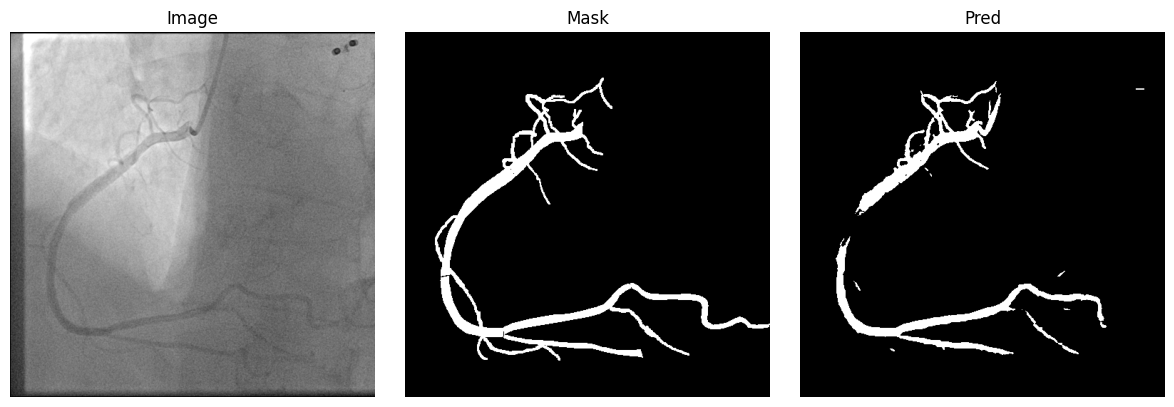

In [8]:
import matplotlib.pyplot as plt

def show_img_mask_pred(img, mask, pred):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for ax, data, title in zip(axs, [img, mask, pred], ['Image', 'Mask', 'Pred']):
        ax.imshow(data, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_img_mask_pred(test_imgs[0], test_masks[0], test_preds[0])